In [1]:
import numpy as np
import pandas as pd
from spec_id import Median_w_Error_cont, Gauss_dist, Stack_posteriors, Gen_grid,Iterative_stacking
import matplotlib.pyplot as plt
from scipy.interpolate import UnivariateSpline, interp1d
import seaborn as sea
# from statsmodels.nonparametric.smoothers_lowess import lowess
sea.set(style='white')
sea.set(style='ticks')
sea.set_style({"xtick.direction": "in", "ytick.direction": "in"})
from time import time
colmap = sea.cubehelix_palette(12, start=2, rot=.2, dark=0, light=1.1, as_cmap=True)

import rpy2
import rpy2.robjects as robjects
from rpy2.robjects.packages import importr
from rpy2.robjects import pandas2ri
R = robjects.r
pandas2ri.activate()

%config InlineBackend.figure_format = 'retina'
%matplotlib inline

In [2]:
galDB = pd.read_pickle('../data/upd_galDB.pkl')
lzDB = galDB.query('z_grism < 1.16')
mzDB = galDB.query('1.16 < z_grism < 1.3')
hzDB = galDB.query('1.3 < z_grism < 1.45')
uhzDB = galDB.query('1.45 < z_grism')


metal=np.round(np.arange(0.002,0.031,0.001),3)
age=np.round(np.arange(.5,6.1,.1),1)
tau=[0,8.0, 8.3, 8.48, 8.6, 8.7, 8.78, 8.85, 8.9, 8.95, 9.0, 9.04, 9.08, 9.11, 9.15, 9.18, 9.2, 9.23, 9.26, 9.28,
     9.3, 9.32, 9.34, 9.36, 9.38, 9.4, 9.41, 9.43, 9.45, 9.46, 9.48]
dust=np.round(np.arange(0.0,1.1,0.1),1)
M,A=np.meshgrid(metal,age)

In [3]:
def Gauss_dist(x, mu, sigma):
    G = (1 / (sigma * np.sqrt(2 * np.pi))) * np.exp(-((x - mu) ** 2) / (2 * sigma ** 2))
    C = np.trapz(G, x)
    G /= C
    return G

def Lognormal_dist(x, mu, sigma):
    G = (1 / (x*sigma * np.sqrt(2 * np.pi))) * np.exp(-((np.log(x) - mu) ** 2) / (2 * sigma ** 2))
    C = np.trapz(G, x)
    G /= C
    return G

In [97]:
x=np.arange(.01,6,.01)
ers = np.arange(0,1.5,0.001)
gdist = Gauss_dist(x,2,0.75)
sp_size = 12


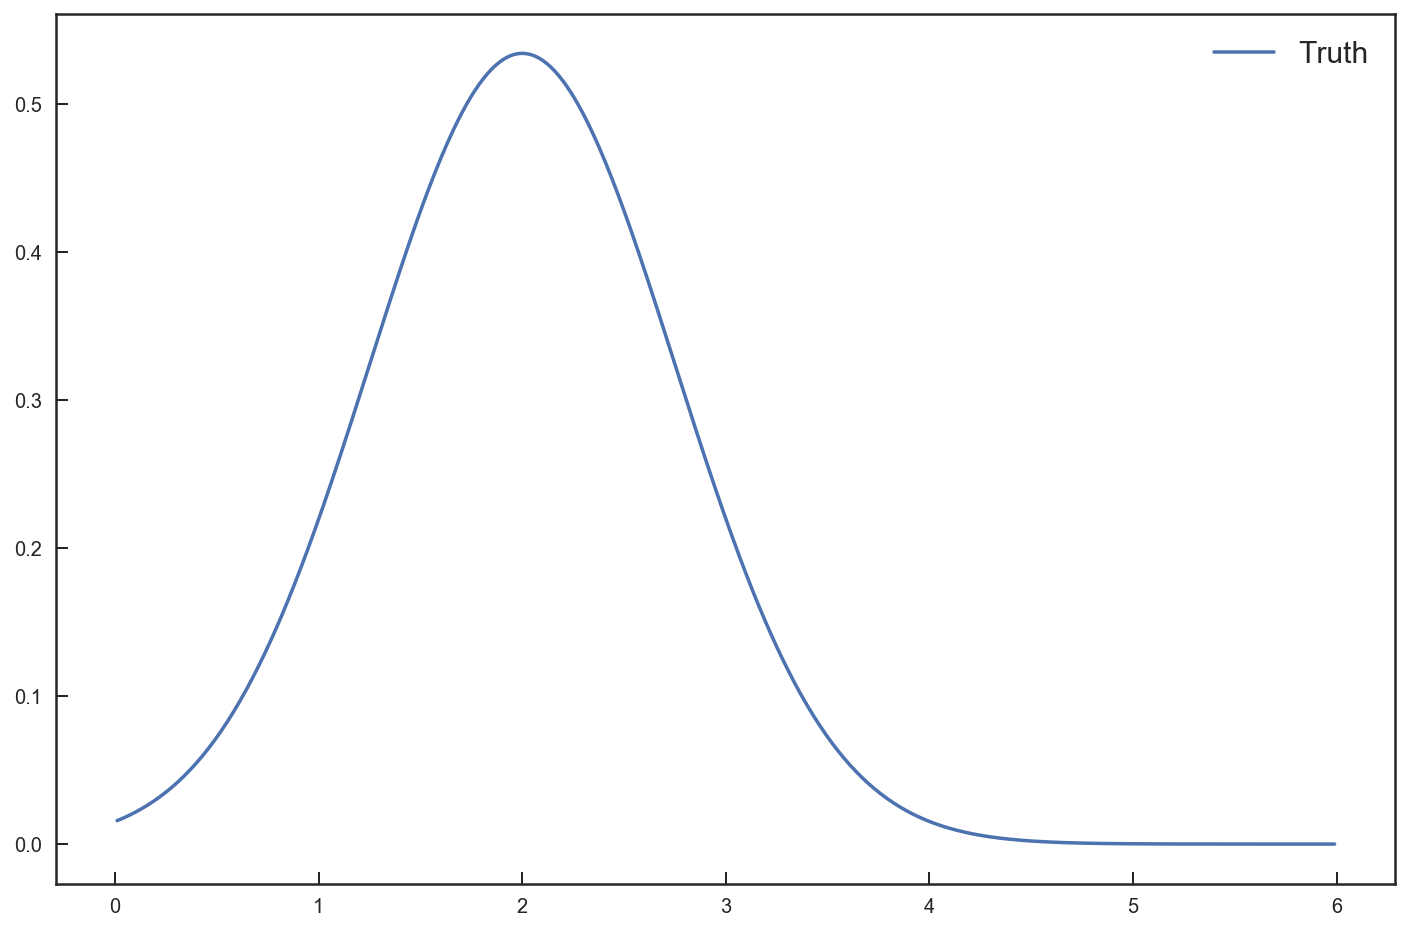

In [98]:
%matplotlib inline
plt.figure(figsize=[12,8])
plt.plot(x,gdist,label='Truth')
# plt.plot(lx,lndist,label='Truth')
plt.legend(fontsize=15)

In [101]:
redx =np.arange(.01,5,.01)
dist_grid= np.zeros([sp_size,redx.size])
for i in range(sp_size):
    dist_grid[i] = Gauss_dist(redx,np.random.normal(2,0.75),np.random.choice(ers))

Text(0.5,1,'Sample Posteriors')

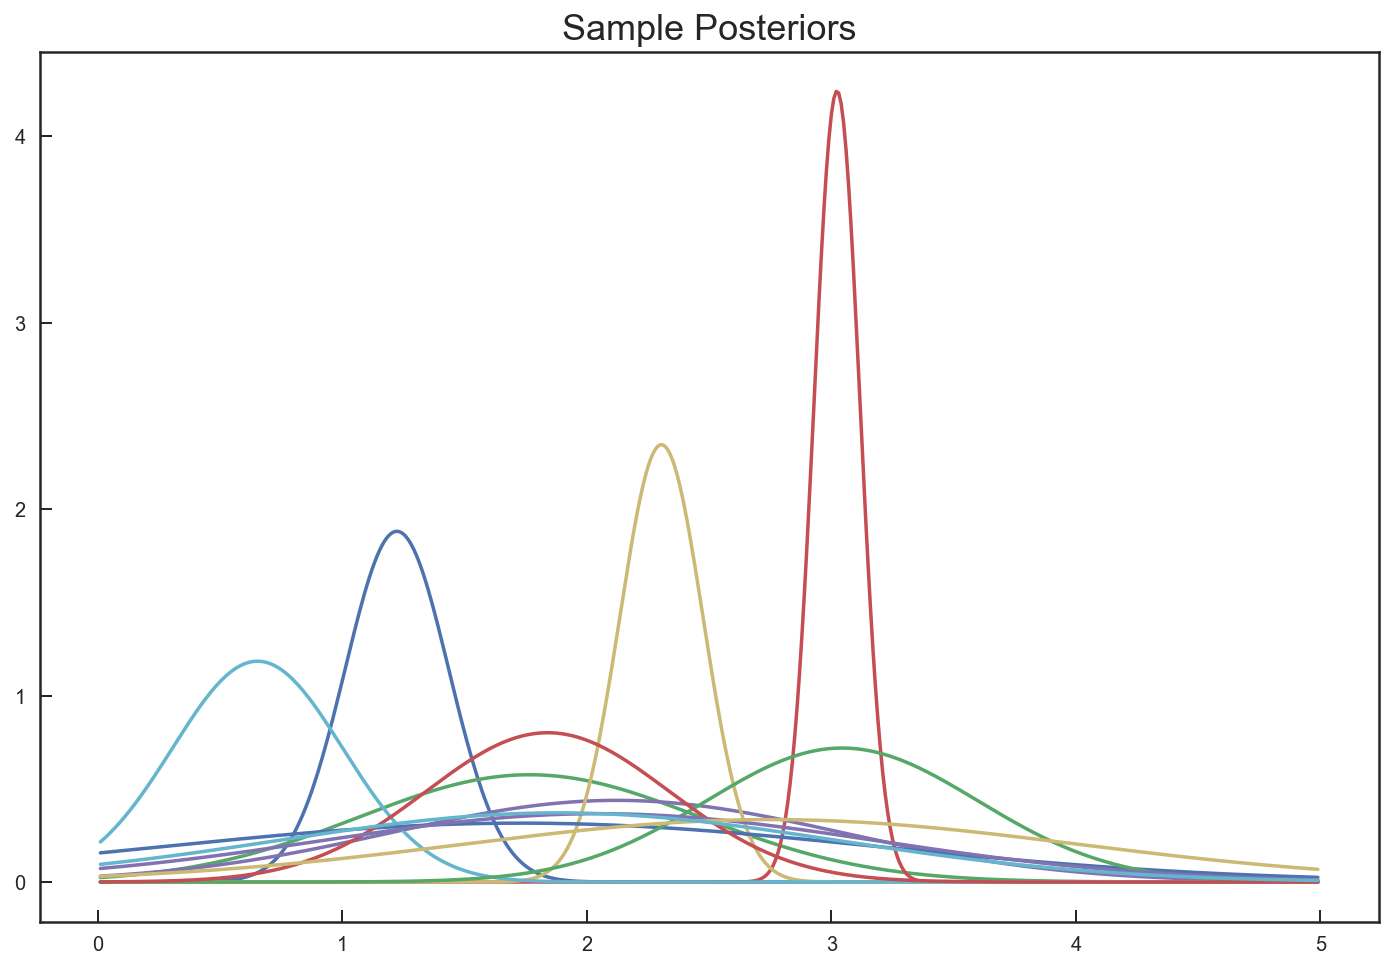

In [102]:
plt.figure(figsize=[12,8])
for i in range(sp_size):
    plt.plot(redx,dist_grid[i])
plt.title('Sample Posteriors', fontsize =18)

In [103]:
# Pos1 = Stack_posteriors(dist_grid,x)
iterpos1,wstk1= Iterative_stacking(dist_grid,redx,2,extend=True,iterations=20,resampling=250)

# Pos2 = Stack_posteriors(newgrid,newx)
iterpos2,wstk2= Iterative_stacking2(dist_grid,redx,2,extend=False,iterations=20,resampling=250)
# iterpos3,iterx3= Iterative_stacking(newgrid2,newx2,resampling=250)


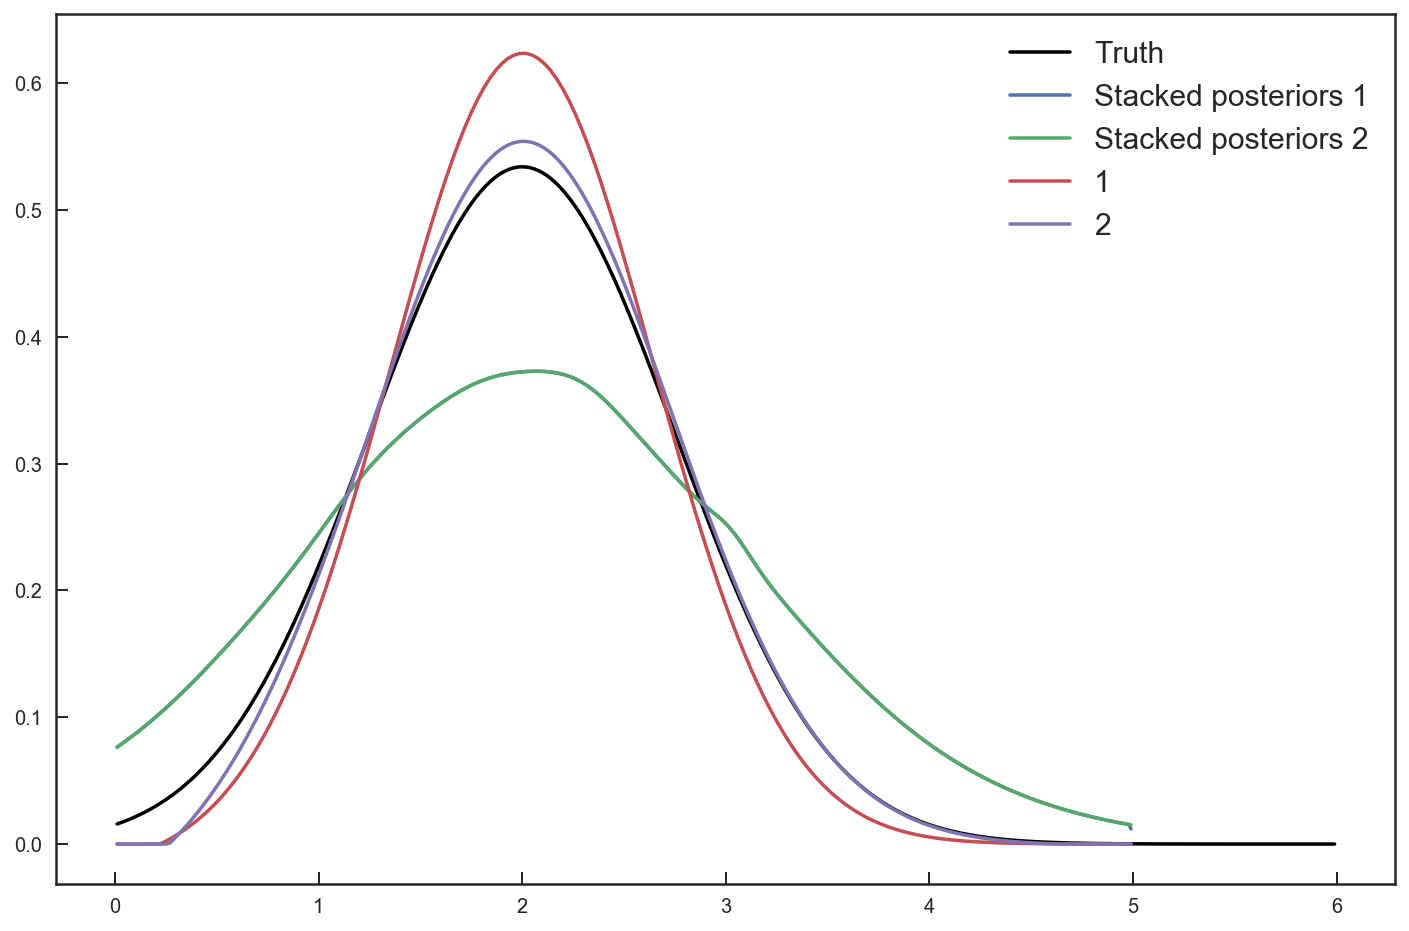

In [104]:
plt.figure(figsize=[12,8])
plt.plot(x,gdist,'k',label = 'Truth')
plt.plot(redx,wstk1,label = 'Stacked posteriors 1')
plt.plot(redx,wstk2,label = 'Stacked posteriors 2')

plt.plot(redx,iterpos1,label = '1')
plt.plot(redx,iterpos2,label = '2')
plt.legend(fontsize = 15)

In [68]:
def Reconfigure_dist(grid,x,roundto):
    g = np.array(grid)
    x = np.round(x,roundto)
            
    delx= x[1] - x[0]
    radx = (max(x) - min(x))/2.
    newx =np.round(np.arange(x[0],x[-1] + radx, delx),roundto)
    regrid = np.zeros([len(g),len(newx)])
    
    for i in range(len(regrid)):
        for ii in range(len(x)):
            if x[ii] in newx:
    
                regrid[i][newx == x[ii]] = g[i][ii]
    return newx,regrid

def Reconfigure_dist2(grid,x,roundto):
    g = np.array(grid)
    x = np.round(x,roundto)
            
    delx= x[1] - x[0]
    radx = (max(x) - min(x))/16.
    newx =np.round(np.arange(x[0],x[-1] + radx, delx),roundto)
    regrid = np.zeros([len(g),len(newx)])
    
    for i in range(len(regrid)):
        for ii in range(len(x)):
            if x[ii] in newx:
    
                regrid[i][newx == x[ii]] = g[i][ii]
    return newx,regrid

def Leave_one_out(dist, x):
    Y = np.zeros(x.size)
    for i in range(len(dist)):
        Y += dist[i]
    Y /= np.trapz(Y, x)

    w = np.arange(.01, 2.01, .01)
    weights = np.zeros(len(dist))
    for i in range(len(dist)):
        Ybar = np.zeros(x.size)
        for ii in range(len(dist)):
            if i != ii:
                Ybar += dist[ii]
        Ybar /= np.trapz(Ybar, x)
        weights[i] = np.sum((Ybar - Y) ** 2) ** -1
    return weights

def Stack_posteriors(P_grid, x):
    P_grid = np.array(P_grid)
    W = Leave_one_out(P_grid,x)
    top = np.zeros(P_grid.shape)
    for i in range(W.size):
        top[i] = W[i] * P_grid[i]
    P =sum(top)/sum(W)
    return P / np.trapz(P,x)

def Iterative_stacking(grid_o,x_o,rto, extend=False, iterations = 20,resampling = 250):
    ksmooth = importr('KernSmooth')
    del_x = x_o[1] - x_o[0]

    if extend:
        x_n,grid_n = Reconfigure_dist(grid_o,x_o,rto)

        x = np.linspace(x_n[0],x_n[-1],resampling)
        grid = np.zeros([len(grid_n),x.size])    
        for i in range(len(grid_n)):
            grid[i] = interp1d(x_n,grid_n[i])(x)
        ### select bandwidth
        H = ksmooth.dpik(x_o) 
    else:
        x = np.linspace(x_o[0],x_o[-1],resampling)
        grid = np.zeros([len(grid_o),x.size])    
        for i in range(len(grid_o)):
            grid[i] = interp1d(x_o,grid_o[i])(x)

        ### select bandwidth
        H = ksmooth.dpik(x)
    ### stack posteriors w/ weights
    stkpos = Stack_posteriors(grid,x)
    ### initialize prior as flat
    Fx = np.ones(stkpos.size)
    
    for i in range(iterations):
        fnew = Fx * stkpos / np.trapz(Fx * stkpos,x)
        fx = ksmooth.locpoly(x,fnew,bandwidth = H)
        X = np.array(fx[0])
        iFX = np.array(fx[1])
        Fx = interp1d(X,iFX)(x)

    Fx[Fx<0]=0
    rsFx = interp1d(x,Fx)(x_o)
    rsFx = rsFx/np.trapz(rsFx,x_o)  
    
    rsstkpos = interp1d(x,stkpos)(x_o)
    rsstkpos = rsstkpos/np.trapz(rsstkpos,x_o)  
    return rsFx,rsstkpos

def Iterative_stacking2(grid_o,x_o,rto, extend=False, iterations = 20,resampling = 250):
    ksmooth = importr('KernSmooth')
    del_x = x_o[1] - x_o[0]

    if extend:
        x_n,grid_n = Reconfigure_dist2(grid_o,x_o,rto)

        x = np.linspace(x_n[0],x_n[-1],resampling)
        grid = np.zeros([len(grid_n),x.size])    
        for i in range(len(grid_n)):
            grid[i] = interp1d(x_n,grid_n[i])(x)
        ### select bandwidth
        H = ksmooth.dpik(x_o) 
    else:
        x = np.linspace(x_o[0],x_o[-1],resampling)
        grid = np.zeros([len(grid_o),x.size])    
        for i in range(len(grid_o)):
            grid[i] = interp1d(x_o,grid_o[i])(x)

        ### select bandwidth
        H = ksmooth.dpik(x)
    ### stack posteriors w/ weights
    stkpos = Stack_posteriors(grid,x)
    ### initialize prior as flat
    Fx = np.ones(stkpos.size)
    
    for i in range(iterations):
        fnew = Fx * stkpos / np.trapz(Fx * stkpos,x)
        fx = ksmooth.locpoly(x,fnew,bandwidth = H)
        X = np.array(fx[0])
        iFX = np.array(fx[1])
        Fx = interp1d(X,iFX)(x)

    Fx[Fx<0]=0
    rsFx = interp1d(x,Fx)(x_o)
    rsFx = rsFx/np.trapz(rsFx,x_o)  
    
    rsstkpos = interp1d(x,stkpos)(x_o)
    rsstkpos = rsstkpos/np.trapz(rsstkpos,x_o)  
    return rsFx,rsstkpos

In [504]:
lzgrid = Gen_grid(lzDB,'Z')

In [531]:
X=metal

Pos = Stack_posteriors(lzgrid,X)
iterpos,iterx = Iterate_stack(lzgrid,X,20)
iterpos4,iterx4 = Iterative_stacking(lzgrid,X,resampling=500)


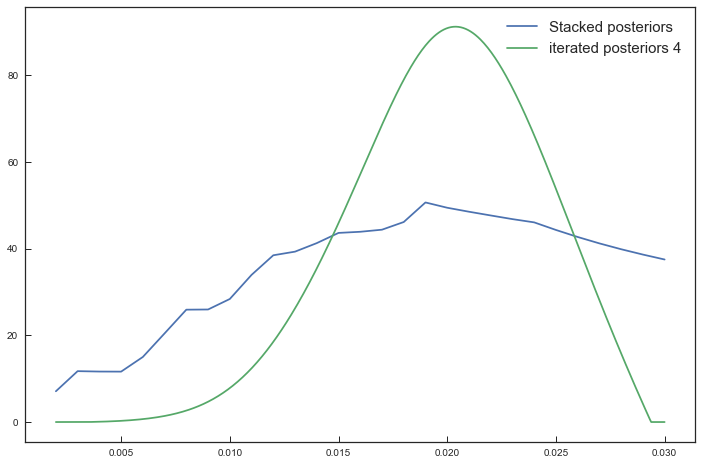

In [534]:
plt.figure(figsize=[12,8])
plt.plot(X,Pos,label = 'Stacked posteriors')
# plt.plot(iterx,iterpos,label = 'iterated posteriors')
plt.plot(iterx4,iterpos4,label = 'iterated posteriors 4')

plt.legend(fontsize = 15)

In [340]:
np.var(age)

2.6124999999999994

In [226]:
def Iterative_stacking(grid_o,x_o,LOG = False,iterations = 20,resampling = 1000):
    del_x = x_o[1] - x_o[0]

    ### resample
    if LOG == False:
        x = np.linspace(x_o[0],x_o[-1],resampling)
    else:
        x = np.logspace(np.log10(x_o[0]),np.log10(x_o[-1]),resampling)
        
    print x
    grid = np.zeros([len(grid_o),x.size])    
    for i in range(len(grid_o)):
        grid[i] = interp1d(x_o,grid_o[i])(x)
   
    ### select bandwidth
    H = ksmooth.dpik(x)
    ### stack posteriors w/ weights
    stkpos = Stack_posteriors(grid,x)
    ### initialize prior as flat
    Fx = np.ones(stkpos.size)
    
    for i in range(iterations):
        fnew = Fx * stkpos / np.trapz(Fx * stkpos,x)
        fx = ksmooth.locpoly(x,fnew,bandwidth = H)
        X = np.array(fx[0])
        iFX = np.array(fx[1])
        Fx = interp1d(X,iFX)(x)

    Fx[Fx<0]=0
    Fx = Fx/np.trapz(Fx,x)
    return Fx,x

# Lognormal plot

In [223]:
dist_grid= np.zeros([sp_size,lx.size])
for i in range(sp_size):
    dist_grid[i] = Lognormal_dist(lx,np.random.normal(3,.75),np.random.choice(ers))

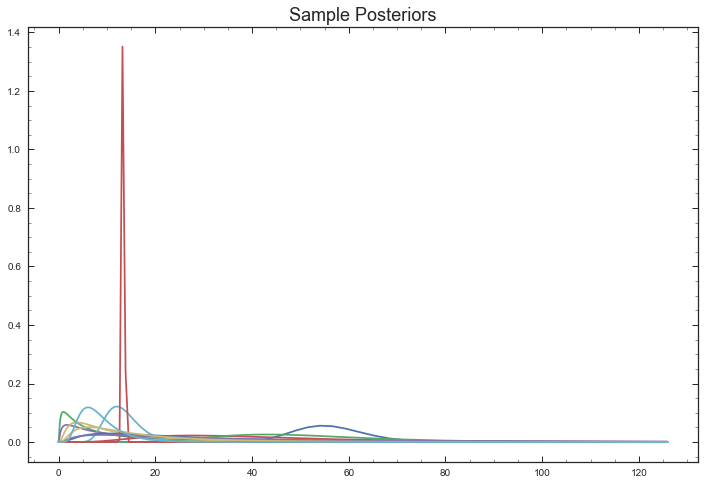

In [224]:
plt.figure(figsize=[12,8])
for i in range(sp_size):
    plt.plot(lx,dist_grid[i])
plt.title('Sample Posteriors', fontsize =18)

In [228]:
Pos = Stack_posteriors(dist_grid,lx)
iterpos,iterx = Iterate_stack(dist_grid,lx,20)
iterpos4,iterx4= Iterative_stacking(dist_grid,lx,LOG=True,iterations=1,resampling=250)

[  1.00000000e-04   1.05803002e-04   1.11942753e-04   1.18438794e-04
   1.25311800e-04   1.32583647e-04   1.40277479e-04   1.48417784e-04
   1.57030472e-04   1.66142954e-04   1.75784234e-04   1.85984997e-04
   1.96777711e-04   2.08196726e-04   2.20278387e-04   2.33061147e-04
   2.46585691e-04   2.60895065e-04   2.76034811e-04   2.92053118e-04
   3.09000968e-04   3.26932301e-04   3.45904190e-04   3.65977019e-04
   3.87214674e-04   4.09684751e-04   4.33458767e-04   4.58612390e-04
   4.85225678e-04   5.13383335e-04   5.43174982e-04   5.74695440e-04
   6.08045030e-04   6.43329898e-04   6.80662347e-04   7.20161199e-04
   7.61952171e-04   8.06168274e-04   8.52950238e-04   9.02446961e-04
   9.54815980e-04   1.01022397e-03   1.06884730e-03   1.13087253e-03
   1.19649709e-03   1.26592984e-03   1.33939178e-03   1.41711672e-03
   1.49935204e-03   1.58635947e-03   1.67841595e-03   1.77581447e-03
   1.87886503e-03   1.98789561e-03   2.10325324e-03   2.22530507e-03
   2.35443958e-03   2.49106777e-03

/Users/Vince.ec/anaconda2/envs/astroconda/lib/python2.7/site-packages/ipykernel/__main__.py:29: RuntimeWarning: invalid value encountered in less


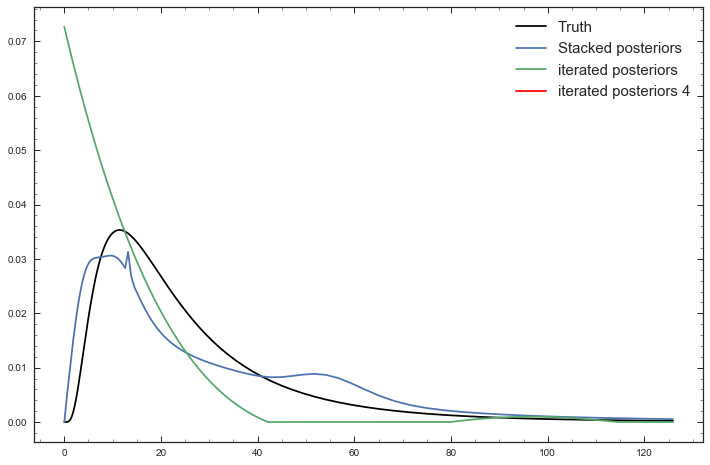

In [229]:
plt.figure(figsize=[12,8])
plt.plot(lx,lndist,'k',label = 'Truth')
plt.plot(lx,Pos,label = 'Stacked posteriors')
plt.plot(iterx,iterpos,label = 'iterated posteriors')
plt.plot(iterx4,iterpos4,'r',label = 'iterated posteriors 4')

plt.legend(fontsize = 15)

In [177]:
def Iterative_stacking(grid_o,x_o,LOG = False,iterations = 20,resampling = 1000):
    del_x = x_o[1] - x_o[0]

    ### resample
    if LOG == False:
        x = np.linspace(x_o[0],x_o[-1],resampling)
    else:
        x = np.logspace(np.log10(x_o[0]),np.log10(x_o[-1]),resampling)
        
    grid = np.zeros([len(grid_o),x.size])    
    for i in range(len(grid_o)):
        grid[i] = interp1d(x_o,grid_o[i])(x)
   
    ### select bandwidth
    H = ksmooth.dpik(x)
    ### stack posteriors w/ weights
    stkpos = Stack_posteriors(grid,x)
    ### initialize prior as flat
    Fx = np.ones(stkpos.size)
    
    for i in range(iterations):
        fnew = Fx * stkpos / np.trapz(Fx * stkpos,x)
        fx = ksmooth.locpoly(x,fnew,bandwidth = H)
        X = np.array(fx[0])
        iFX = np.array(fx[1])
        Fx = interp1d(X,iFX)(x)

    Fx[Fx<0]=0
    Fx = Fx/np.trapz(Fx,x)
    return Fx,x

299999

# Binomial Distribution

In [36]:
x = np.linspace(0,10,100)

d1 = Gauss_dist(x,2,0.5)
d1 /= np.trapz(d1,x)
d2 = Gauss_dist(x,7,0.5)
d1 /= np.trapz(d2,x)

d3 = d1 + d2
d3 /= np.trapz(d3,x)

In [23]:
def Bimod_choice(mu1,sig1,mu2,sig2, X, size):
    Y = np.zeros(size)
    
    w = 0
    
    while w < size:
        test = np.random.rand()
        if test > 0.5:
            Y[w] = np.random.normal(mu1,sig1)
        else:
            Y[w] = np.random.normal(mu2,sig2)
            
        w+=1
        
    return Y

In [37]:
pts = Bimod_choice(2,0.5,7,0.5,x,1000)

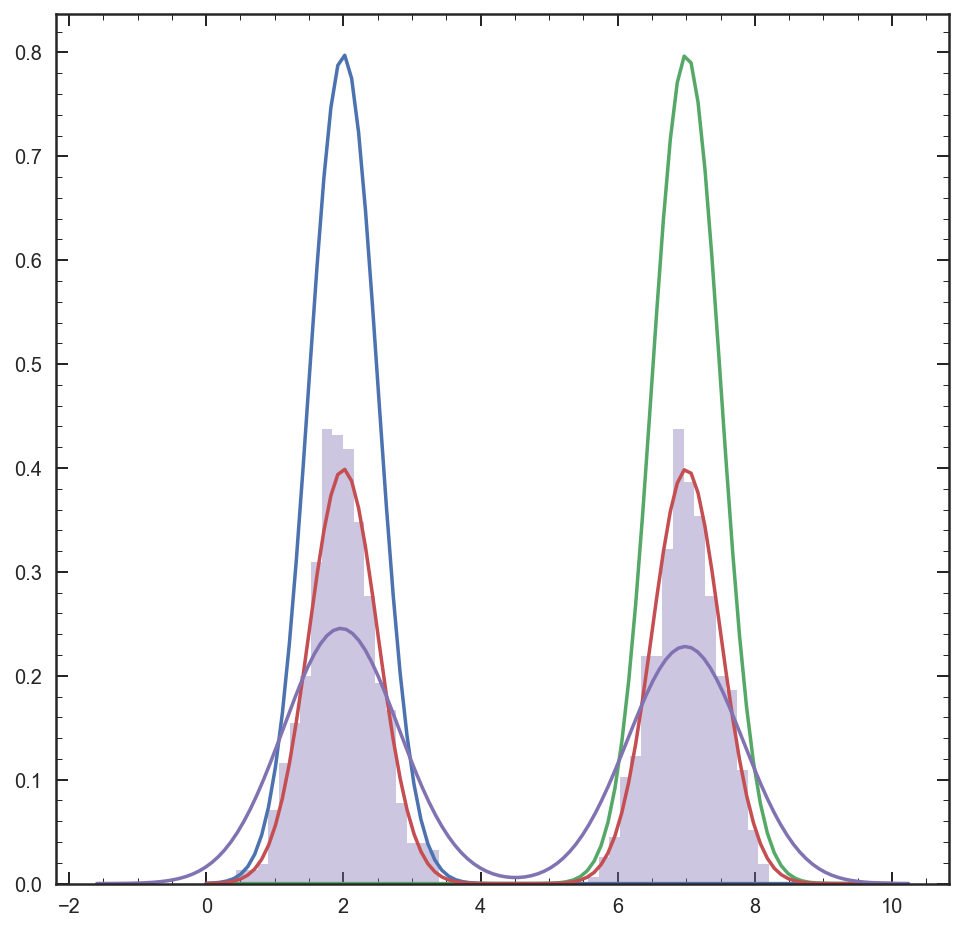

In [38]:
plt.figure(figsize=[8,8])
plt.plot(x,d1)
plt.plot(x,d2)
plt.plot(x,d3)
sea.distplot(pts,bins= 50)

In [71]:
sp_size=100
ers = np.arange(0,1,0.001)

dist_grid= np.zeros([sp_size,x.size])
for i in range(sp_size):
    test = np.random.rand()
    if test > 0.5:
        dist_grid[i] = Gauss_dist(x,np.random.normal(2,.5),np.random.choice(ers))
    else:
        dist_grid[i] = Gauss_dist(x,np.random.normal(7,.5),np.random.choice(ers))

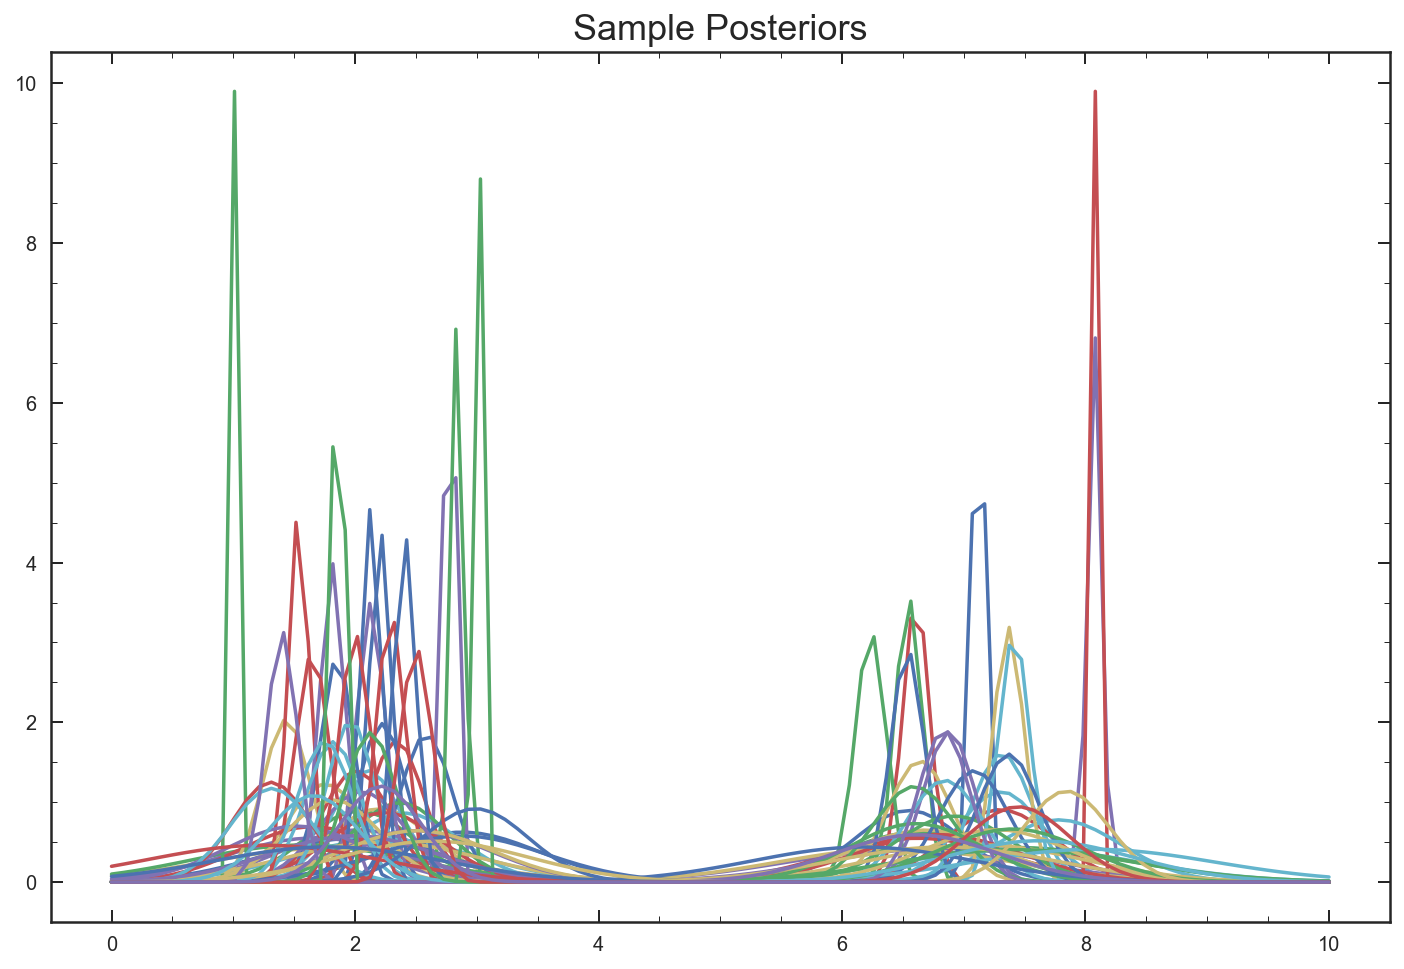

In [72]:
plt.figure(figsize=[12,8])
for i in range(sp_size):
    plt.plot(x,dist_grid[i])
plt.title('Sample Posteriors', fontsize =18)

In [73]:
Pos = Stack_posteriors(dist_grid,x)
iterpos,iterx = Iterative_stacking(dist_grid,x,iterations=20)


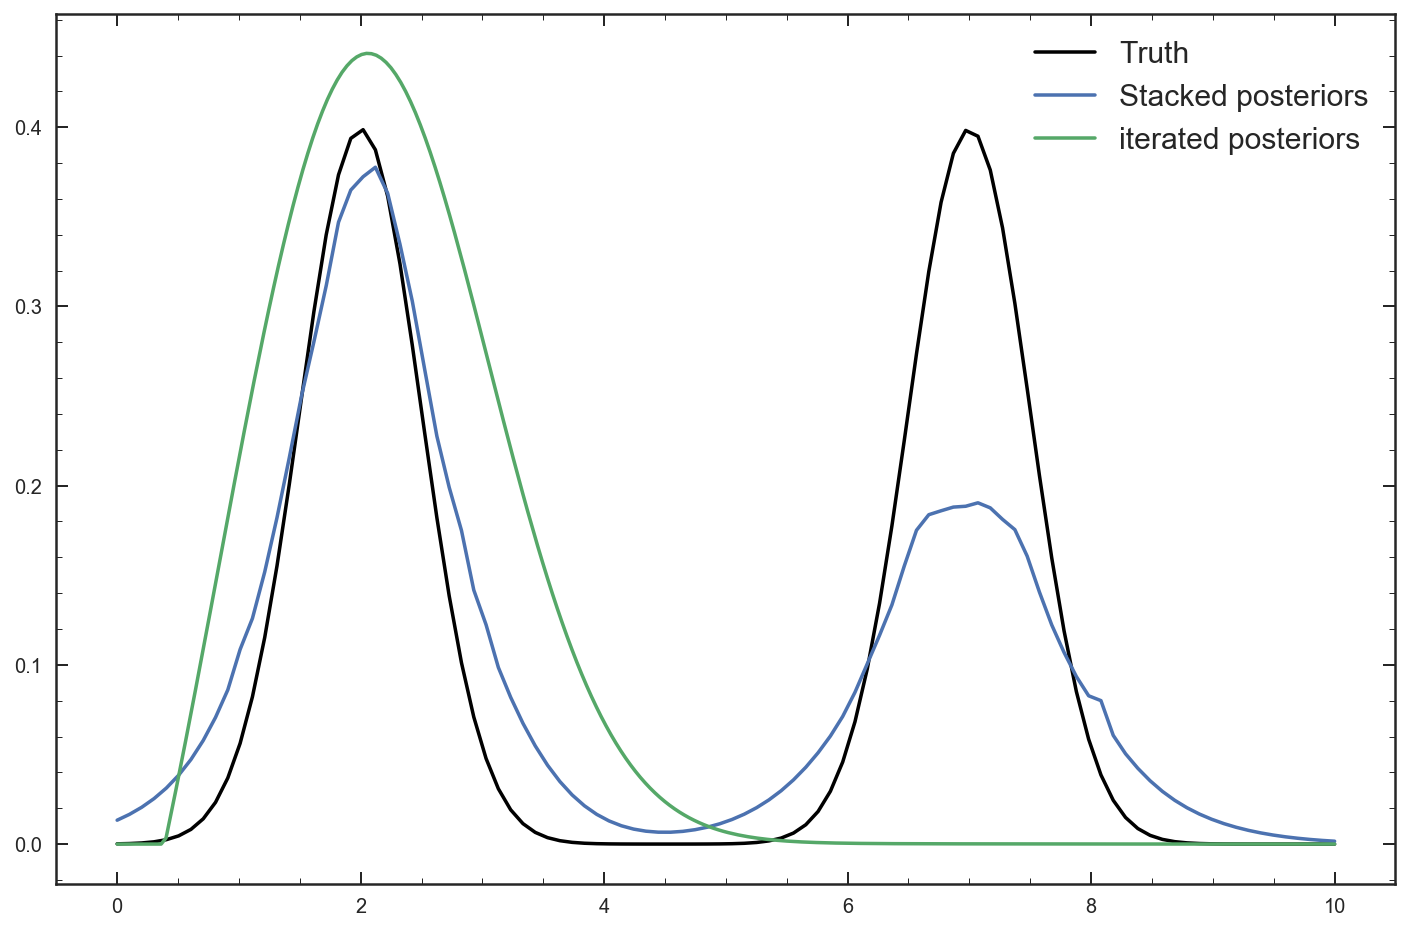

In [74]:
plt.figure(figsize=[12,8])
plt.plot(x,d3,'k',label = 'Truth')
plt.plot(x,Pos,label = 'Stacked posteriors')
plt.plot(iterx,iterpos,label = 'iterated posteriors')
plt.legend(fontsize = 15)

In [70]:
def Leave_one_out(dist, x):
    Y = np.zeros(x.size)
    for i in range(len(dist)):
        Y += dist[i]
    Y /= len(dist)

    w = np.arange(.01, 2.01, .01)
    weights = np.zeros(len(dist))
    for i in range(len(dist)):
        Ybar = np.zeros(x.size)
        for ii in range(len(dist)):
            if i != ii:
                Ybar += dist[ii]
        Ybar /= (len(dist)-1)
        weights[i] = np.trapz((Ybar - Y) ** 2,x) ** -1
    return weights

def Stack_posteriors(P_grid, x):
    P_grid = np.array(P_grid)
    W = Leave_one_out(P_grid,x)
    top = np.zeros(P_grid.shape)
    for i in range(W.size):
        top[i] = W[i] * P_grid[i]
    P =sum(top)#/sum(W)
    return P / np.trapz(P,x)

def Iterative_stacking_test(grid_o,x_o,iterations = 20,resampling = 250):
    ksmooth = importr('KernSmooth')
    del_x = x_o[1] - x_o[0]

    ### resample
    x = np.linspace(x_o[0],x_o[-1],resampling)
    grid = np.zeros([len(grid_o),x.size])    
    for i in range(len(grid_o)):
        grid[i] = interp1d(x_o,grid_o[i])(x)
   
    ### select bandwidth
    H = ksmooth.dpik(x)
    ### stack posteriors w/ weights
    stkpos = Stack_posteriors(grid,x)
    ### initialize prior as flat
    Fx = np.ones(stkpos.size)
    
    for i in range(iterations):
        fnew = Fx * stkpos / np.trapz(Fx * stkpos,x)
        fx = ksmooth.locpoly(x,fnew,bandwidth = H)
        X = np.array(fx[0])
        iFX = np.array(fx[1])
        Fx = interp1d(X,iFX)(x)

    Fx[Fx<0]=0
    Fx = Fx/np.trapz(Fx,x)
    return Fx,x

# additional penalty

In [77]:
def Reconfigure_dist(grid,x,roundto):
    g = np.array(grid)
    x = np.round(x,roundto)
            
    delx= x[1] - x[0]
    radx = (max(x) - min(x))/2.
    newx =np.round(np.arange(x[0] ,x[-1] + radx, delx),roundto)
    regrid = np.zeros([len(g),len(newx)])
    
    for i in range(len(regrid)):
        for ii in range(len(x)):
            if x[ii] in newx:
    
                regrid[i][newx == x[ii]] = g[i][ii]
    return newx,regrid

def Leave_one_out(dist, x):
    Y = np.zeros(x.size)
    for i in range(len(dist)):
        Y += dist[i]
    Y /= np.trapz(Y, x)

    w = np.arange(.01, 2.01, .01)
    weights = np.zeros(len(dist))
    for i in range(len(dist)):
        Ybar = np.zeros(x.size)
        for ii in range(len(dist)):
            if i != ii:
                Ybar += dist[ii]
        Ybar /= np.trapz(Ybar, x)
        weights[i] = np.sum((Ybar - Y) ** 2) ** -1
    return weights

def Stack_posteriors(P_grid, x):
    P_grid = np.array(P_grid)
    W = Leave_one_out(P_grid,x)
    top = np.zeros(P_grid.shape)
    for i in range(W.size):
        top[i] = W[i] * P_grid[i]
    P =sum(top)/sum(W)
    return P / np.trapz(P,x)

def Iterative_stacking(grid_o,x_o,rto, extend=False, iterations = 20,resampling = 250):
    ksmooth = importr('KernSmooth')
    del_x = x_o[1] - x_o[0]

    if extend:
        x_n,grid_n = Reconfigure_dist(grid_o,x_o,rto)

        x = np.linspace(x_n[0],x_n[-1],resampling)
        grid = np.zeros([len(grid_n),x.size])    
        for i in range(len(grid_n)):
            grid[i] = interp1d(x_n,grid_n[i])(x)
    
    else:
        x = np.linspace(x_o[0],x_o[-1],resampling)
        grid = np.zeros([len(grid_o),x.size])    
        for i in range(len(grid_o)):
            grid[i] = interp1d(x_o,grid_o[i])(x)

    ### select bandwidth
    H = ksmooth.dpik(x)
    ### stack posteriors w/ weights
    stkpos = Stack_posteriors(grid,x)
    ### initialize prior as flat
    Fx = np.ones(stkpos.size)
    
    for i in range(iterations):
        fnew = Fx * stkpos / np.trapz(Fx * stkpos,x)
        fx = ksmooth.locpoly(x,fnew,bandwidth = H)
        X = np.array(fx[0])
        iFX = np.array(fx[1])
        Fx = interp1d(X,iFX)(x)

    Fx[Fx<0]=0
    rsFx = interp1d(x,Fx)(x_o)
    rsFx = rsFx/np.trapz(rsFx,x_o)  
    
    rsstkpos = interp1d(x,stkpos)(x_o)
    rsstkpos = rsstkpos/np.trapz(rsstkpos,x_o)  
    return rsFx,rsstkpos

In [76]:
def Gen_grid(DB,param):
    grid=[]
    for i in DB.index:
        x,Px = np.load('../chidat/{0}_full_fit_{1}_pos.npy'.format(DB['gids'][i],param))
        grid.append(Px)
    return np.array(grid)

def Reconfigure_dist2(grid,x,roundto):
    g = np.array(grid)
    x = np.round(x,roundto)
            
    delx= x[1] - x[0]
    radx = (max(x) - min(x))/2.
    newx =np.round(np.arange(x[0] - radx,x[-1] + radx, delx),roundto)
    regrid = np.zeros([len(g),len(newx)])
    
    for i in range(len(regrid)):
        for ii in range(len(x)):
            if x[ii] in newx:
                regrid[i][newx == x[ii]] = g[i][ii]
    return newx,regrid

def Leave_one_out2(dist, x):
    Y = np.zeros(x.size)
    for i in range(len(dist)):
        Y += dist[i]
    Y /= np.trapz(Y, x)

    w = np.arange(.01, 2.01, .01)
    weights = np.zeros(len(dist))
    for i in range(len(dist)):
        Ybar = np.zeros(x.size)
        for ii in range(len(dist)):
            if i != ii:
                Ybar += dist[ii]
        Ybar /= np.trapz(Ybar, x)
        weights[i] = np.sum((Ybar - Y) ** 2) ** -1
    return weights

def Stack_posteriors2(P_grid, x):
    P_grid = np.array(P_grid)
    W = Leave_one_out(P_grid,x)

    top = np.zeros(P_grid.shape)
    for i in range(W.size):
        top[i] = W[i] * P_grid[i]
    P =sum(top)/sum(W)
    return P / np.trapz(P,x)


def Iterative_stacking2(grid_o,x_o,rto, extend=False, iterations = 20,resampling = 250):
    ksmooth = importr('KernSmooth')
    del_x = x_o[1] - x_o[0]

    if extend:
        x_n,grid_n = Reconfigure_dist2(grid_o,x_o,rto,3)

        x = np.linspace(x_n[0],x_n[-1],resampling)
        grid = np.zeros([len(grid_n),x.size])    
        for i in range(len(grid_n)):
            grid[i] = interp1d(x_n,grid_n[i])(x)
    
    else:
        x = np.linspace(x_o[0],x_o[-1],resampling)
        grid = np.zeros([len(grid_o),x.size])    
        for i in range(len(grid_o)):
            grid[i] = interp1d(x_o,grid_o[i])(x)

    ### select bandwidth
    H = ksmooth.dpik(x)
    ### stack posteriors w/ weights
    stkpos = Stack_posteriors(grid,x)
    ### initialize prior as flat
    Fx = np.ones(stkpos.size)
    
    for i in range(iterations):
        fnew = Fx * stkpos / np.trapz(Fx * stkpos,x)
        fx = ksmooth.locpoly(x,fnew,bandwidth = H)
        X = np.array(fx[0])
        iFX = np.array(fx[1])
        Fx = interp1d(X,iFX)(x)

    Fx[Fx<0]=0
    rsFx = interp1d(x,Fx)(x_o)
    rsFx = rsFx/np.trapz(rsFx,x_o)  
    
    rsstkpos = interp1d(x,stkpos)(x_o)
    rsstkpos = rsstkpos/np.trapz(rsstkpos,x_o)  
    return rsFx,rsstkpos

In [117]:
PZl_grid = Gen_grid(lzDB,'Z')
PZ1,PZ1s = Iterative_stacking(PZl_grid,metal,3,extend=True,resampling=250)
PZ2,PZ2s = Iterative_stacking2(PZl_grid,metal,3,extend=True,resampling=250)

In [118]:
print(Median_w_Error_cont(PZ1,metal))
print(Median_w_Error_cont(PZ2,metal))

(0.02377154308617234, 0.005218436873747491, 0.003927855711422845)
(0.02500601202404809, 0.005330661322645286, 0.0034789579158316652)


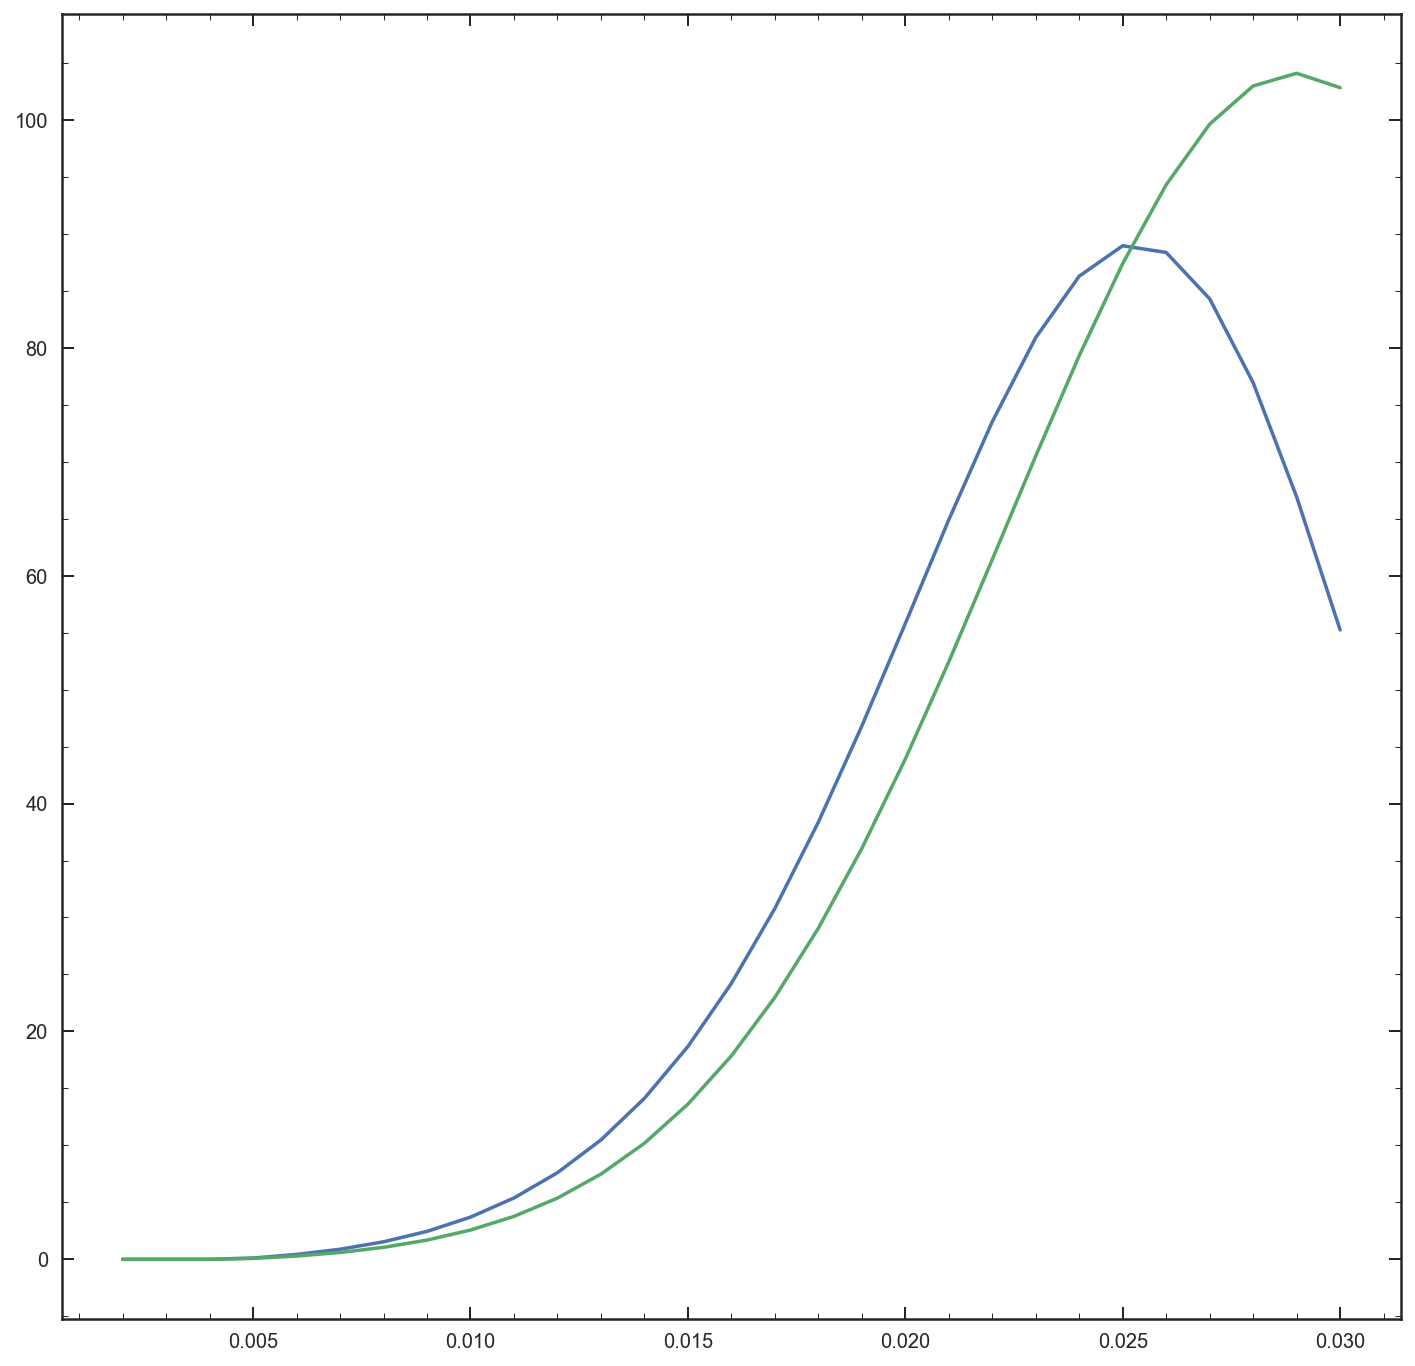

In [119]:
plt.figure(figsize=[12,12])
plt.plot(metal,PZ1)
plt.plot(metal,PZ2)
# plt.plot(age,wPZl)
# plt.plot(age,PZ2s)

In [200]:
w[w == min(w)] = 0

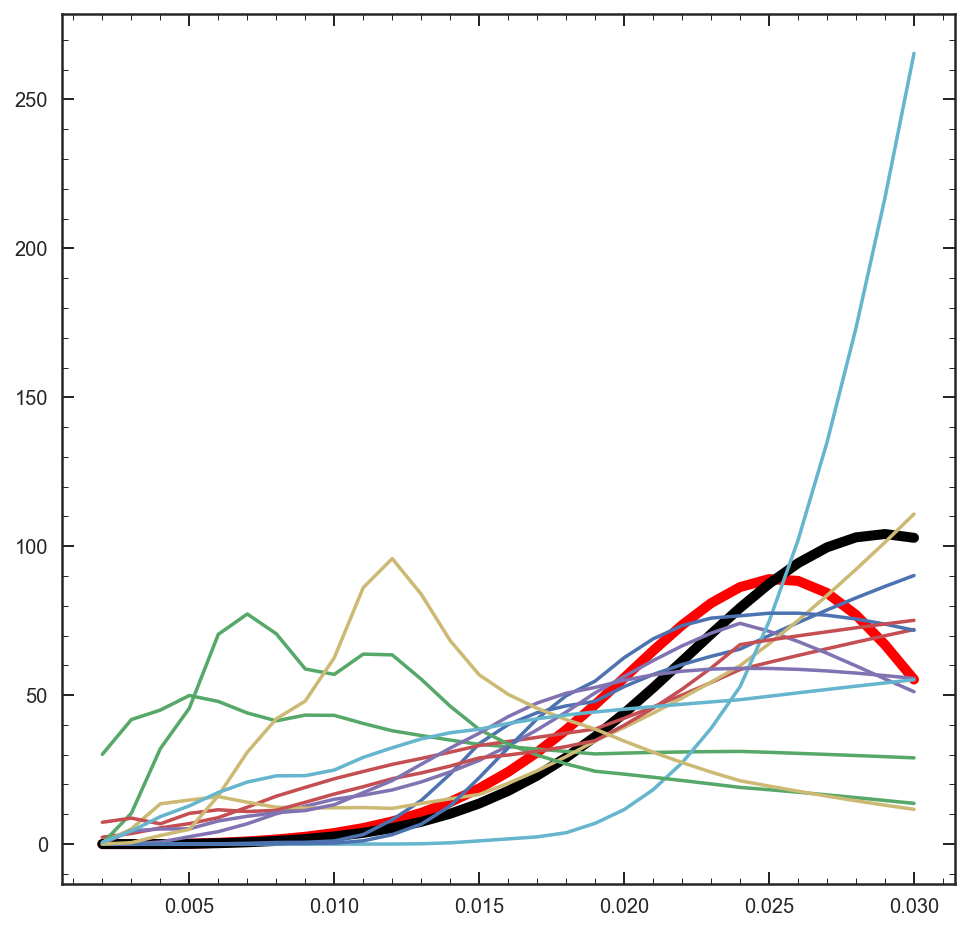

In [120]:
plt.figure(figsize=[8,8])

plt.plot(metal,PZ1,'r',linewidth = 5)
plt.plot(metal,PZ2,'k',linewidth = 5)
for i in range(len(PZl_grid)):
    plt.plot(metal,PZl_grid[i])